In [1]:
import git
import os
import pandas as pd
import numpy as np
import networkx as nx

In [27]:
repo_name = "gptwrapper"

# check if the repository exists at ./tmp/repo_name
# if it does, pull the latest changes
# if it doesn't, clone the repository
def get_repo():
    if os.path.exists(f"./tmp/{repo_name}"):
        # Git pull the latest changes
        repo = git.Repo(f"./tmp/{repo_name}")
        repo.remotes.origin.pull()
        return repo
    else:
        # Git clone the repository into ./tmp
        url = f"https://github.com/UniversityOfHelsinkiCS/{repo_name}"
        return git.Repo.clone_from(url, f"./tmp/{repo_name}")
    
repo = get_repo()

In [50]:
# Find all files in the repository (./tmp/repo)
file_names = set()

for root, dirs, dir_files in os.walk(f"./tmp/{repo_name}"):
    
    for file in dir_files:
        fname = os.path.join(root, file)
        file_names.add(fname.replace(f"./tmp/{repo_name}/", ""))
    if ".git" in dirs:
        dirs.remove(".git")

In [32]:
df = None

if os.path.exists(f"./tmp/{repo_name}_changes.csv"):
    df = pd.read_csv(f"./tmp/{repo_name}_changes.csv")
else:
    authors = set()
    source_files = set()
    changes = []

    for commit in repo.iter_commits('main'):
        authors.add(commit.author.name)

        for item in commit.stats.files:
            if item not in fnames:
                continue
            source_files.add(item)
            changes.append({
                'commit': commit.hexsha,
                'file': item,
                'insertions': commit.stats.files[item]['insertions'],
                'deletions': commit.stats.files[item]['deletions'],
                'author': commit.author.name,
                'date': commit.authored_datetime
            })
        
        print("#", end="")

    df = pd.DataFrame(changes)

    df.to_csv(f"./tmp/{repo_name}_changes.csv", index=False)


In [54]:
adjacency_df = None

if os.path.exists(f"./tmp/{repo_name}_adjacency.csv"):
    adjacency_df = pd.read_csv(f"./tmp/{repo_name}_adjacency.csv")
else:
    file_idx = list(file_names)
    adjacency_df = pd.DataFrame(index=file_idx, columns=file_idx, dtype=float)
    adjacency_df = adjacency_df.fillna(0)

    # Count the number of times each file is changed with each other file
    for fnames in df.groupby(df["commit"])["file"].apply(list):
        for file in fnames:
            for other_file in fnames:
                if file == other_file:
                    continue
                adjacency_df.loc[file, other_file] = adjacency_df.loc[file, other_file] + 1

    adjacency_df.to_csv(f"./tmp/{repo_name}_adjacency.csv")

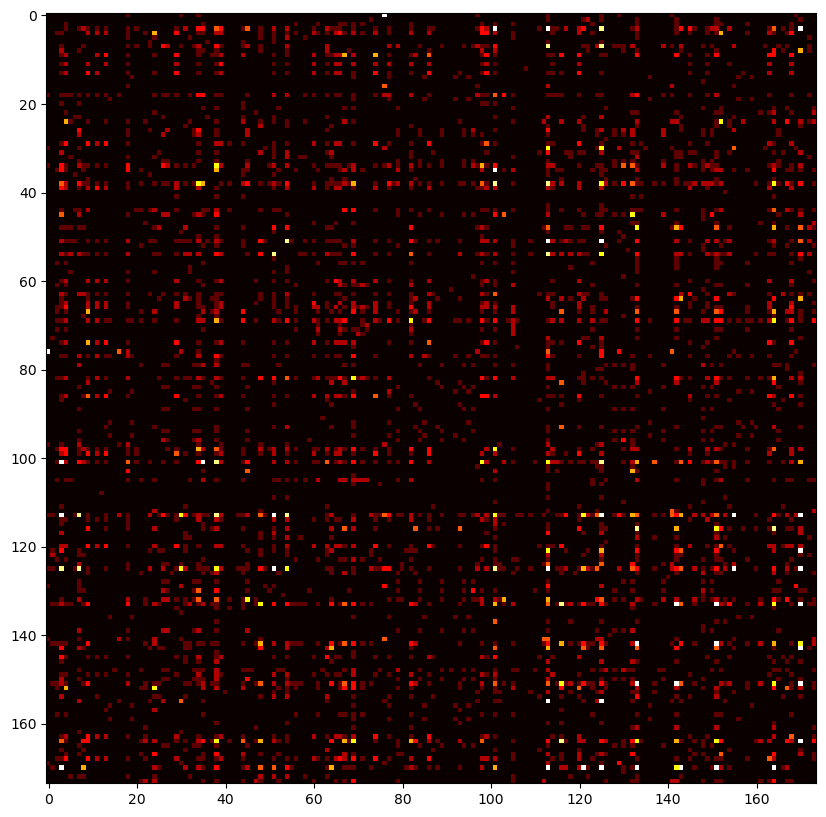

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(adjacency_df, cmap='hot', interpolation='nearest', vmax=8)

[1. 1. 1. ... 2. 1. 1.]


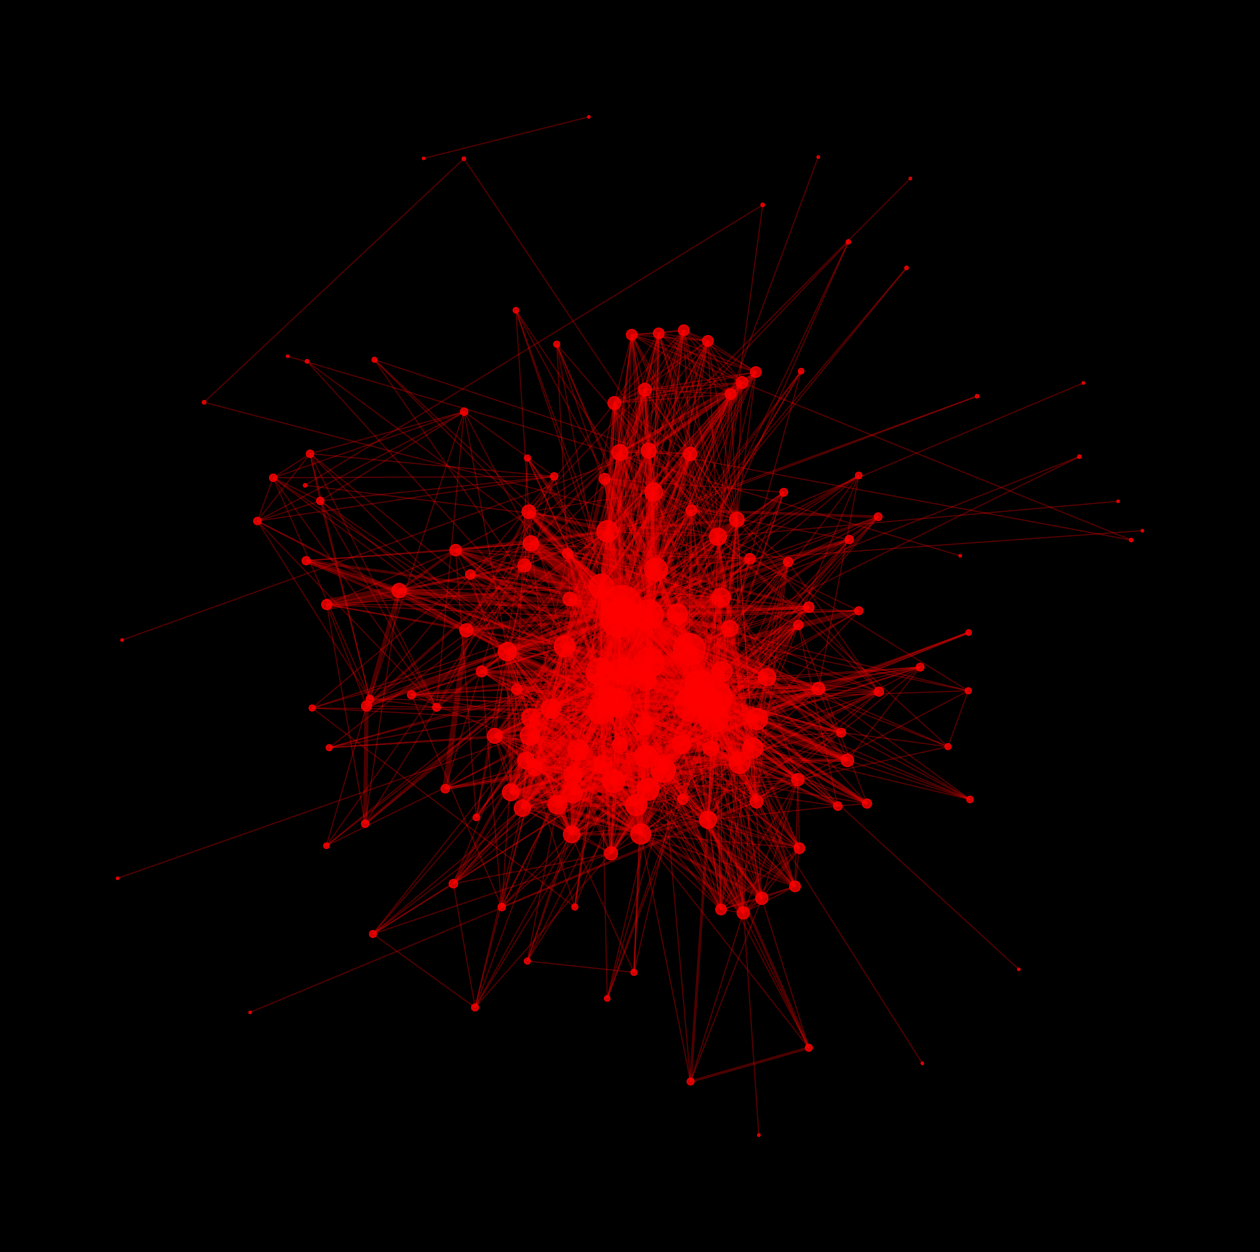

In [55]:
adjacency_df = adjacency_df
node_sizes = adjacency_df.sum(axis=1).mul(3)

graph = nx.from_pandas_adjacency(adjacency_df)

layout = nx.spring_layout(
    graph,
    k=0.6,
    seed=42,
    weight='weight',
)

weights = np.fromiter(map(lambda x: x[2]['weight'], graph.edges(data=True)), dtype=np.float32)
print(weights)

fig, ax = plt.subplots()
fig.set_facecolor('black')

nx.draw_networkx_edges(graph, layout, 
    width=np.minimum(weights, 10),
    alpha=0.3,
    edge_color="red",
    # edge_cmap=plt.colormaps["hot"],
    # edge_vmin=0,
    # edge_vmax=4,
    ax=ax
)

nx.draw_networkx_nodes(graph, layout,
    node_size=node_sizes,
    node_color='red',
    alpha=0.8,
    ax=ax
)

# nx.draw_networkx_labels(graph, layout, font_size=6)

fig.set_size_inches(16, 16)
plt.axis('off')
plt.show()

In [ ]:
layout = nx.kamada_kawai_layout(
    graph,
    weight='weight',
)

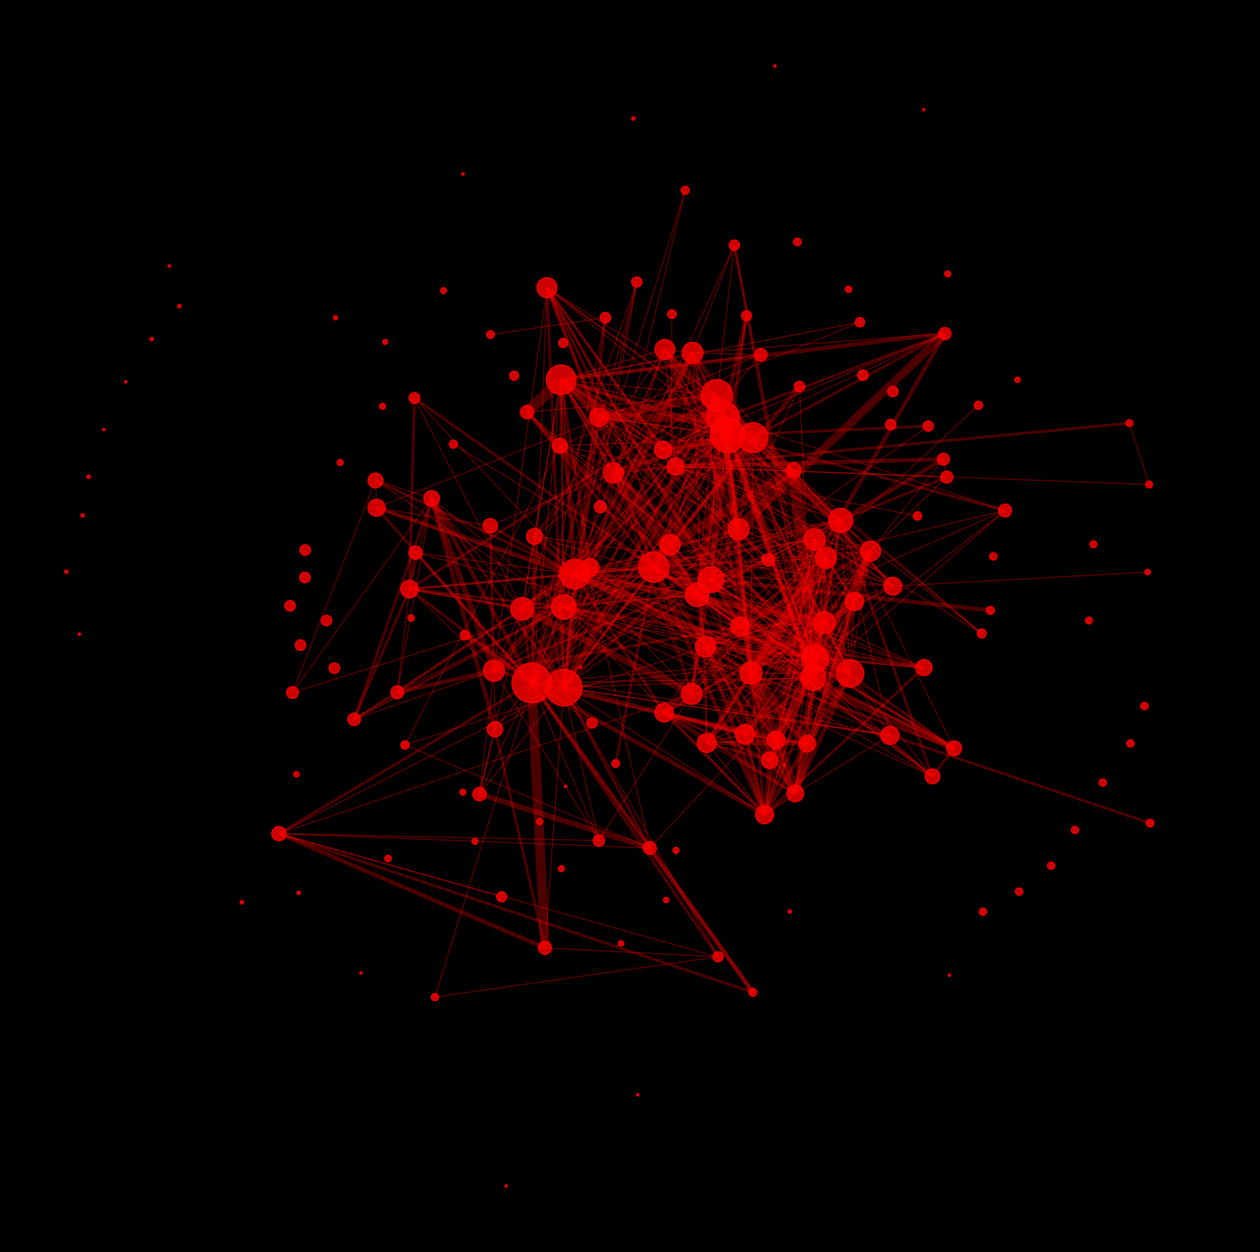

In [45]:
fig, ax = plt.subplots()
fig.set_facecolor('black')

nx.draw_networkx_edges(graph, layout,
    width=np.minimum(weights, 10),
    alpha=0.3,
    edge_color="red",
    # edge_cmap=plt.colormaps["hot"],
    # edge_vmin=0,
    # edge_vmax=4,
    ax=ax
)

nx.draw_networkx_nodes(graph, layout,
    node_size=node_sizes,
    node_color='red',
    alpha=0.8,
    ax=ax
)

# nx.draw_networkx_labels(graph, layout, font_size=6)

fig.set_size_inches(16, 16)
plt.axis('off')
plt.show()